In [1]:
import xarray
#from dask_jobqueue import SLURMCluster
#from dask.distributed import Client
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal as scipy_signal
from scipy import linalg as scipy_linalg
from scipy.integrate import trapz
from scipy.fft import fftfreq,fftshift
import pandas
import cartopy.crs as ccrs
import xeof

import event_analysis
import RAMA_reader
#import coare36vnWarm_et as coare_bulk_flux

In [2]:
import sys

MODULE_FULL_PATH = '/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5'

sys.path.insert(1, MODULE_FULL_PATH)
from coare35vn import coare35vn as coare_surface_flux_35  #import coare36vnWarm_et


In [3]:
RAMA_file_path = '/tube1/cha674/Tropical_Indian_Ocean/RAMA_Moorings/Update/RAMA_Array/'
atmosphere_mooring_object = RAMA_reader.construct_object_for_variables(RAMA_file_path,['SW_rad','LW_rad','Wind','T_air','RH','SLP','Rain'],sampling_frequency='hourly')
ocean_mooring_object = RAMA_reader.construct_object_for_variables(RAMA_file_path,['SST','SSS'],sampling_frequency='hourly')

Looking for variable:  SW_rad
Looking for variable:  LW_rad
Looking for variable:  Wind
Looking for variable:  T_air
Looking for variable:  RH
Looking for variable:  SLP
Looking for variable:  Rain
Looking for variable:  SST
Looking for variable:  SSS


In [4]:
SW_rad_RAMA  = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'SW_rad')
LW_rad_RAMA  = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'LW_rad')
wind_RAMA  = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'Wind')
T_air_RAMA = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'T_air')
RH_RAMA    = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'RH')
Rain_RAMA  = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'Rain')
SLP_RAMA  = RAMA_reader.read_data_for_variable(atmosphere_mooring_object,'SLP')

SST_RAMA   =  RAMA_reader.read_data_for_variable(ocean_mooring_object,'SST')
SSS_RAMA   =  RAMA_reader.read_data_for_variable(ocean_mooring_object,'SSS')

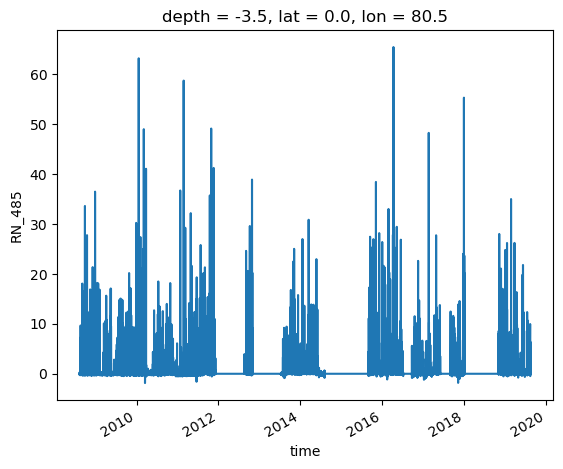

In [5]:
Rain_RAMA['0n80.5e']['RN_485'].fillna(0).plot()

In [6]:
RAMA_locations = T_air_RAMA.keys()
for i_location in  RAMA_locations:
    print(i_location)
    T_air_at_location       =  T_air_RAMA[i_location] ['AT_21'] #.mean(dim='depth').squeeze()
    T_air_times             =  T_air_RAMA[i_location]['time']
    T_air_instrument_height = float(np.abs( T_air_RAMA[i_location]['AT_21']['depth']) )     #.astype('float')

    wind_speed_at_location       =  wind_RAMA[i_location] ['WS_401'] #.mean(dim='depth').squeeze()
    wind_speed_time              =  wind_RAMA[i_location]['time']
    wind_speed_instrument_height = float(np.abs(wind_RAMA[i_location] ['WS_401']['depth'].values) )#.astype('float')
    
    
    RH_at_location          =  RH_RAMA[i_location] ['RH_910'] #.mean(dim='depth').squeeze()
    RH_time                 =  RH_RAMA[i_location]['time']
    RH_instrument_height    =  float(np.abs(RH_RAMA[i_location] ['RH_910']['depth'].values)) #.astype('float')

    SST_at_location         =  SST_RAMA[i_location]['T_25'] #.mean(dim='depth').squeeze() #.sel(time=T_air_at_location['time'],method='nearest')
    SST_time                =  SST_RAMA[i_location]['time']
    SST_instrument_depth    =   float(np.abs(SST_RAMA[i_location]['T_25']['depth'].values)) #.astype('float')
    #print(SST_depth)
    #SSS_at_location         =  SSS_RAMA[i_location]['S_41'].values #.mean(dim='depth').squeeze() #.sel(time=T_air_at_location['time'],method='nearest')
    #SSS_time                =  SSS_at_location['time'].values
    
    #rain_at_location        = Rain_RAMA[i_location]['RN_485'].fillna(0).sum(dim='depth')
    #rain_time               = Rain_RAMA[i_location]['time']

    
    common_times_1  = np.intersect1d(T_air_times,wind_speed_time) 
    common_times_2  = np.intersect1d(RH_time,SST_time)
    common_times    = np.intersect1d(common_times_1,common_times_2)
    
    
    
    lat_at_location = T_air_RAMA[i_location]['latitude']
    lon_at_location = T_air_RAMA[i_location]['longitude']
    

    
    SW_rad_at_location      =  SW_rad_RAMA[i_location]['RD_495'] #.sel(time=common_times,method='nearest') #.mean(dim='depth').squeeze().sel(time=common_times)
    SW_rad_times            = SW_rad_RAMA[i_location]['time']
    
    SW_common_times = np.intersect1d(SW_rad_times,common_times)
    
    SW_rad_at_location     = SW_rad_at_location.sel(time=SW_common_times)
    T_air_at_location      = T_air_at_location.sel(time=SW_common_times)
    wind_speed_at_location = wind_speed_at_location.sel(time=SW_common_times)
    RH_at_location         = RH_at_location.sel(time=SW_common_times)
    SST_at_location        = SST_at_location.sel(time=SW_common_times)
    #rain_at_location       = rain_at_location.sel(time=SW_common_times)
    SSS_at_location        = 34.5*np.ones(SW_common_times.size) #SSS_at_location.sel(time=SW_common_times)

    
    
    if 'depth' in  SW_rad_at_location.dims:
        SW_rad_at_location = SW_rad_at_location.mean(dim='depth')
    
    SW_rad_time             =  SW_rad_at_location['time']
    
    #if i_location in SLP_RAMA.keys():
    #    SLP_at_location      =  SLP_RAMA[i_location]['BP_915'].sel(time=SW_common_times).values
    #else:
    SLP_at_location = 1015*np.ones(SW_common_times.size)
    if i_location in LW_rad_RAMA.keys():
        LW_rad_at_location      =  LW_rad_RAMA[i_location]['Ql_136'].values
    else:
        LW_rad_at_location = 400*np.ones(SW_common_times.size)
    
    julian_date = xarray.DataArray(np.zeros(SW_common_times.size),dims=['time'],coords={'time':SW_common_times})['time'].dt.dayofyear.values
    
    inversion_height = 600  #*np.ones(SW_common_times.size)
    wind_speed_instrument_height = wind_speed_instrument_height #*np.ones(SW_common_times.size)
    T_air_instrument_height = T_air_instrument_height# * np.ones(SW_common_times.size)     #.astype('float')
    RH_instrument_height    = RH_instrument_height #* np.ones(SW_common_times.size)
    lat_at_location         = lat_at_location #* np.ones(SW_common_times.size)
    lon_at_location         = lon_at_location# * np.ones(SW_common_times.size)
    SST_instrument_depth    = SST_instrument_depth #* np.ones(SW_common_times.size)
    
    
    wind_speed_at_location = wind_speed_at_location.values
    T_air_at_location      = T_air_at_location.values
    RH_at_location         = RH_at_location.values
    SST_at_location         = SST_at_location.values
    SW_rad_at_location     = SW_rad_at_location.values
    #rain_at_location        = rain_at_location.values

    LW_rad_at_location      = 400.0*np.ones(SW_common_times.size)
    SLP_at_location         = 1015.0*np.ones(SW_common_times.size)
    rain_at_location        = 0*np.ones(SW_common_times.size)

    surface_flux = coare_surface_flux_35(wind_speed_at_location,T_air_at_location, RH_at_location, SST_at_location,
                                       P=1015, Rs=SW_rad_at_location, Rl=400, zu=wind_speed_instrument_height, zt=T_air_instrument_height, zq=RH_instrument_height, lat=lat_at_location,
                                       zi=600, rain=None, cp=None, sigH=None, jcool=1)
#list1 = [tau,hsb,hlb,hbb,Rnl,Rns]
    #list2 = [Qs,Qrf]
#    
    wind_stress_at_location       = surface_flux[:,0]  #N/m^2
    sens_heat_flux_at_location    = surface_flux[:,1]  #W/m^2
    latent_heat_flux_at_location  = surface_flux[:,2]  #W/m^2
    buoyancy_flux_at_location     = surface_flux[:,3]  #W/m^2
    net_LW_at_location            = surface_flux[:,4]
    net_SW_at_location            = surface_flux[:,5]

    specific_humidity_water = surface_flux[:,6]
    specific_humidity_air = surface_flux[:,7]
    
    surface_flux_dataset = xarray.DataArray(wind_stress_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])}).to_dataset(name='wind_stress')
    surface_flux_dataset['sensible_heat_flux'] = xarray.DataArray(sens_heat_flux_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})
    
    surface_flux_dataset['latent_heat_flux'] = xarray.DataArray(latent_heat_flux_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})
    surface_flux_dataset['buoyancy_flux'] = xarray.DataArray(buoyancy_flux_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})

    surface_flux_dataset['specific_humidity_air'] = xarray.DataArray(specific_humidity_air[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})
    surface_flux_dataset['specific_humidity_water'] = xarray.DataArray(specific_humidity_water[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})
    surface_flux_dataset['net_LW'] = xarray.DataArray(net_LW_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})
    surface_flux_dataset['net_SW'] = xarray.DataArray(net_SW_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location]),'lon':np.asarray([lon_at_location])})
    

    
    output_file_path = '/tube1/cha674/Tropical_Indian_Ocean/RAMA_Moorings/Update/COARE35_Fluxes'
    file_name        = 'surface_flux_' + i_location + '_hr.nc'
    
    print('Writting: ',file_name)
    surface_flux_dataset.to_netcdf(os.path.join(output_file_path,file_name))
    #LW_rad_at_location      =  LW_rad_RAMA[i_location] 

    #dsa
    

12s93e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:919: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/m

Writting:  surface_flux_12s93e_hr.nc
1.5s67e
Writting:  surface_flux_1.5s67e_hr.nc
1.5n67e
Writting:  surface_flux_1.5n67e_hr.nc
5s95e
Writting:  surface_flux_5s95e_hr.nc
0n80.5e
Writting:  surface_flux_0n80.5e_hr.nc
4s57e
Writting:  surface_flux_4s57e_hr.nc
4s67e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:919: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/m

Writting:  surface_flux_4s67e_hr.nc
8n67e
Writting:  surface_flux_8n67e_hr.nc
8s80.5e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:919: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/m

Writting:  surface_flux_8s80.5e_hr.nc
0n90e
Writting:  surface_flux_0n90e_hr.nc
8s67e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:919: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/m

Writting:  surface_flux_8s67e_hr.nc
0n67e
Writting:  surface_flux_0n67e_hr.nc
1.5s80.5e
Writting:  surface_flux_1.5s80.5e_hr.nc
12n90e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:155: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/

Writting:  surface_flux_12n90e_hr.nc
12s55e
Writting:  surface_flux_12s55e_hr.nc
4s80.5e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:155: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/

Writting:  surface_flux_4s80.5e_hr.nc
8n90e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:155: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/

Writting:  surface_flux_8n90e_hr.nc
12s80.5e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:155: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/

Writting:  surface_flux_12s80.5e_hr.nc
4n90e
Writting:  surface_flux_4n90e_hr.nc
12s67e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:892: RuntimeWarning: invalid value encountered in greater
  k50 = util.find(zetu > 50)   # stable with thin M-O length relative to zu
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:898: RuntimeWarning: invalid value encountered in less
  k = util.find(Ribu < 0)
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:207: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:213: RuntimeWarning: invalid value encountered in less
  k = find(zet < 0)         # unstable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/meteo.py:155: RuntimeWarning: invalid value encountered in greater
  dzet[dzet>50] = 50.           # stable
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/

Writting:  surface_flux_12s67e_hr.nc
8s95e
Writting:  surface_flux_8s95e_hr.nc
15n90e
Writting:  surface_flux_15n90e_hr.nc
15n65e
Writting:  surface_flux_15n65e_hr.nc
8s55e


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:919: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:1135: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut/du


Writting:  surface_flux_8s55e_hr.nc


/tube1/cha674/Tropical_Indian_Ocean/COARE35/COARE-algorithm/Python/COARE3.5/coare35vn.py:1369: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut/du


In [6]:
surface_flux.shape

(74690, 8)

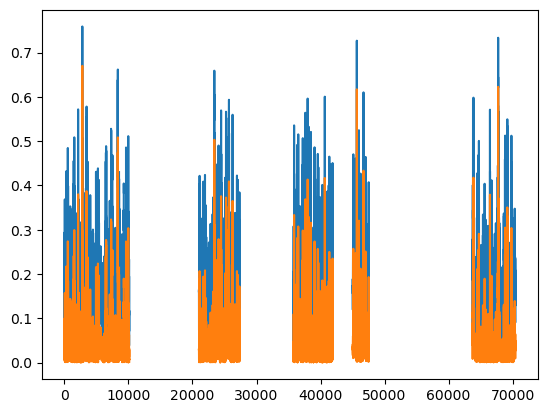

In [28]:
plt.plot(wind_stress_at_location)
plt.plot(sens_heat_flux_at_location)

In [37]:
SW_rad_at_location.size

81591

In [38]:
SST_at_location.size

81591

In [39]:
RH_at_location.size

81591

In [28]:
    surface_flux_dataset = xarray.DataArray(wind_stress_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])}).to_dataset(name='wind_stress')
    surface_flux_dataset['sensible_heat_flux'] = xarray.DataArray(sens_heat_flux_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})
    
    surface_flux_dataset['latent_heat_flux'] = xarray.DataArray(latent_heat_flux_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})
    surface_flux_dataset['buoyancy_flux'] = xarray.DataArray(buoyancy_flux_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})

    surface_flux_dataset['specific_humidity_air_at_location'] = xarray.DataArray(specific_humidity_air_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})
    surface_flux_dataset['specific_water_air_at_location'] = xarray.DataArray(specific_humidity_water_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})
    surface_flux_dataset['net_LW_at_location'] = xarray.DataArray(net_LW_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})
    surface_flux_dataset['net_SW_at_location'] = xarray.DataArray(net_SW_at_location[:,np.newaxis,np.newaxis],dims=['time','lat','lon'],
                                            coords={'time':SW_common_times,'lat':np.asarray([lat_at_location[0]]),'lon':np.asarray([lon_at_location[0]])})
    

    
    output_file_path = '/tube1/cha674/Tropical_Indian_Ocean/RAMA_Moorings/Update/COARE36_Fluxes'
    file_name        = 'surface_flux_' + i_location + '_hr.nc'
    
    print('Writting: ',file_name)
    surface_flux_dataset.to_netcdf(os.path.join(output_file_path,file_name))
    #LW_rad_at_location      =  LW_rad_RAMA[i_location] 

    #dsa

Writting:  surface_flux_12s80.5e_hr.nc


In [27]:
lon_at_location

array([80.5, 80.5, 80.5, ..., 80.5, 80.5, 80.5])

In [26]:
surface_flux_dataset

NameError: name 'surface_flux_dataset' is not defined

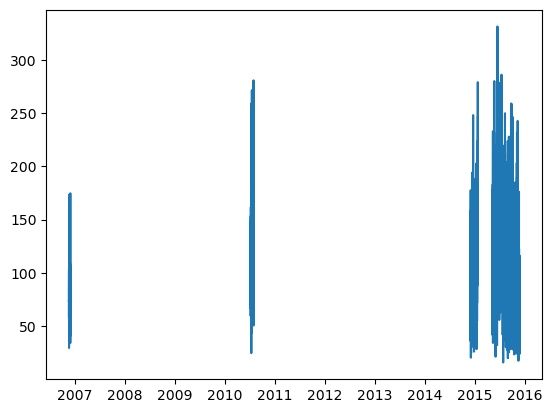

In [17]:
plt.plot(SW_common_times,surface_flux[:,3])
#plt.plot(SW_common_times,wind_speed_at_location)

#plt.plot(SW_common_times,surface_flux[:,28])

In [35]:
SST_RAMA[i_location]['time']

(90935,)

In [31]:
SW_rad_time

<xarray.DataArray 'time' (time: 74690)>
array(['2010-05-18T02:00:00.000000000', '2010-05-18T03:00:00.000000000',
       '2010-05-18T04:00:00.000000000', ..., '2020-10-01T06:00:00.000000000',
       '2020-10-01T07:00:00.000000000', '2020-10-01T08:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-05-18T02:00:00 ... 2020-10-01T08:00:00
    lat      float32 -12.0
    lon      float32 80.5

In [30]:
SW_common_times

array(['2010-05-18T02:00:00.000000000', '2010-05-18T03:00:00.000000000',
       '2010-05-18T04:00:00.000000000', ...,
       '2020-10-01T06:00:00.000000000', '2020-10-01T07:00:00.000000000',
       '2020-10-01T08:00:00.000000000'], dtype='datetime64[ns]')

In [23]:
julian_date.shape

(74690,)

In [24]:
T_air_at_location.shape

(74690,)

In [25]:
RH_at_location.shape

(74690,)

In [26]:
SLP_at_location.shape

(90840,)

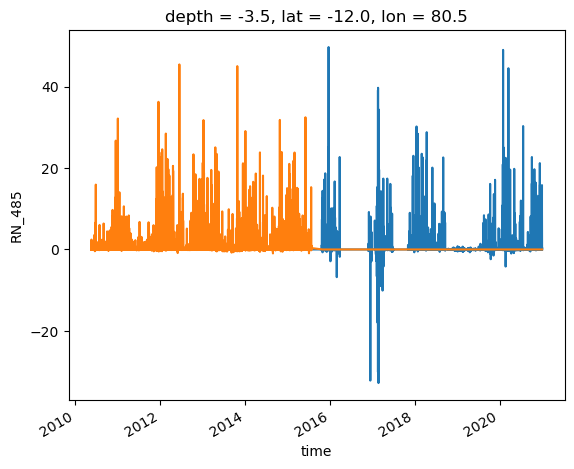

In [20]:
rain_at_location[:,0].plot()
rain_at_location[:,1].plot()

In [9]:
rain_at_location.shape

(74690, 2)

In [14]:
T_air_RAMA[i_location].keys()

dict_keys(['latitude', 'longitude', 'data_variables', 'time', 'AT_21', 'SAT_6021', 'time2', 'QAT_5021'])

In [8]:
SW_rad_at_location.shape

(34529,)

In [6]:
surface_flux

NameError: name 'surface_flux' is not defined

In [21]:
wind_speed_instrument_height

array([4., 4., 4., ..., 4., 4., 4.])

In [19]:
lat_at_location

<xarray.DataArray 'lat' ()>
array(0., dtype=float32)
Coordinates:
    depth    float32 1.0
    lat      float32 0.0
    lon      float32 67.0
Attributes:
    FORTRAN_format:  
    units:           degree_north
    type:            EVEN
    epic_code:       500

In [11]:
wind_speed_instrument_height

4.0

In [45]:
dir(coare_bulk_flux)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

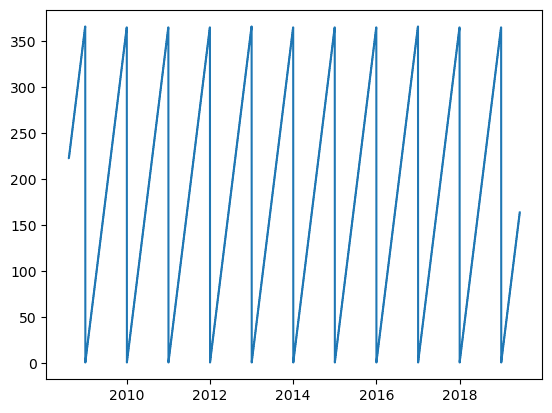

In [15]:
plt.plot(blah['time'],blah['time'].dt.dayofyear)

In [17]:
print(blah['time'][0])
print(blah['time'].dt.dayofyear[0])

<xarray.DataArray 'time' ()>
array('2008-08-10T11:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2008-08-10T11:00:00
<xarray.DataArray 'dayofyear' ()>
array(223)
Coordinates:
    time     datetime64[ns] 2008-08-10T11:00:00


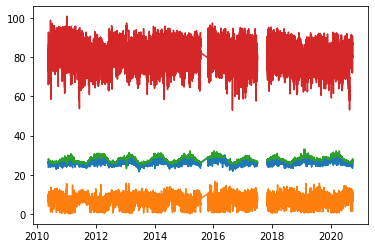

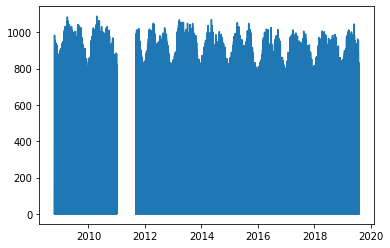

In [93]:
plt.figure(1)
plt.plot(T_air_at_location['time'],T_air_at_location)
plt.plot(wind_speed_at_location['time'],wind_speed_at_location)
plt.plot(SST_at_location['time'],SST_at_location)
plt.plot(RH_at_location['time'],RH_at_location)
plt.figure(2)

plt.plot(SW_rad_at_location['time'],SW_rad_at_location) #.mean(dim='depth'))
#plt.plot(SLP_at_location['time'],SLP_at_location)

In [72]:
SW_rad_at_location.mean(dim='depth').

<xarray.DataArray 'RD_495' (time: 108194)>
array([0. , 0. , 0. , ..., 0.2, 0.2, 0.2], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2008-08-20T05:00:00 ... 2021-01-01T11:00:00
    lat      float32 -4.0
    lon      float32 80.5

In [26]:
RH_at_location.size

45875

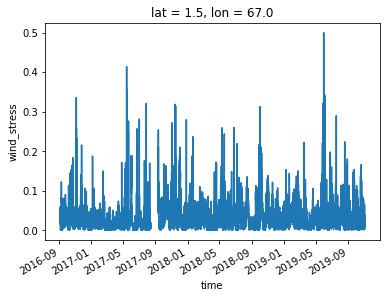

In [105]:
surface_flux_dataset['wind_stress'].plot()
#surface_flux_dataset['sensible_heat_flux'].plot()
#surface_flux_dataset['latent_heat_flux'].plot()

In [ ]:
coare35vn.coare35vn(u, t, rh, ts, P=1015, Rs=150, Rl=370, zu=18, zt=18, zq=18, lat=45,
             zi=600, rain=None, cp=None, sigH=None, jcool=1)